# MobileNet V2

### Imports

In [3]:
import numpy as np
from glob import glob
import os
import cv2


from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model,load_model, Sequential
from tensorflow.keras.layers import  GlobalAveragePooling2D, Dropout, Dense, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import  Adam
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

### Data Paths

In [4]:
train_path = '/kaggle/input/intel-image-classification-mobilenet/seg_train/seg_train'
test_path = '/kaggle/input/intel-image-classification-mobilenet/seg_test/seg_test'

### Load Data

In [5]:
image_size = (150, 150) # 150x150 pixels

def load_images(path):
    X = []
    y = []

    folders = sorted(os.listdir(path), key=lambda x: os.path.getmtime(os.path.join(path, x)))

    for i, folder in enumerate(folders):
        for file in os.listdir(os.path.join(path, folder)):
            img = cv2.imread(os.path.join(path, folder, file))
            img = cv2.resize(img, image_size)
            X.append(img)
            y.append(i)

    return np.array(X), np.array(y)

X_train, y_train = load_images(train_path)
X_test, y_test = load_images(test_path)

### Number of Classes

In [6]:
numberOfClass = len(glob(train_path + "/*"))
print("Number Of Class: ", numberOfClass)

Number Of Class:  6


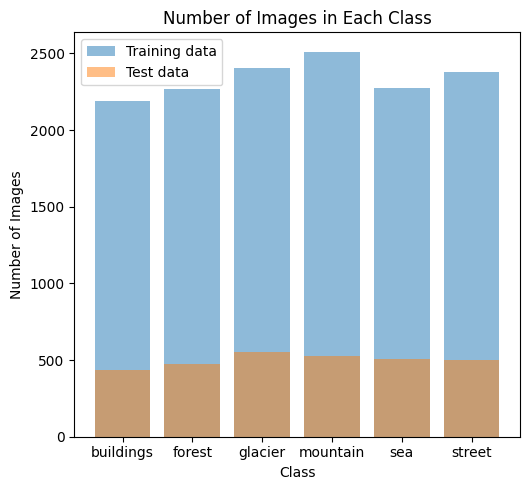

In [7]:
labels = {0: 'buildings', 1: 'forest', 2: 'glacier', 3: 'mountain', 4: 'sea', 5: 'street'}
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.bar(*np.unique(y_train, return_counts=True), label='Training data', alpha=0.5)
plt.bar(*np.unique(y_test, return_counts=True), label='Test data', alpha=0.5)
plt.title('Number of Images in Each Class')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.xticks(range(len(labels)), labels.values())
plt.legend()
plt.tight_layout()
plt.show()

### Show Data

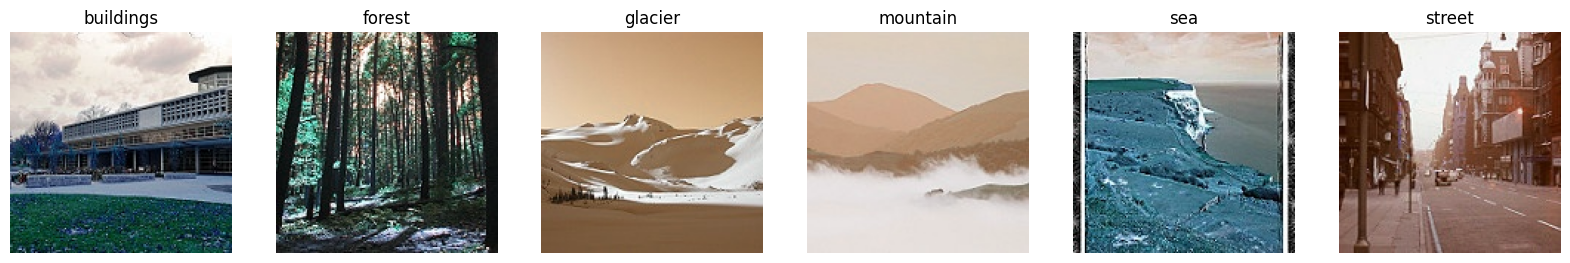

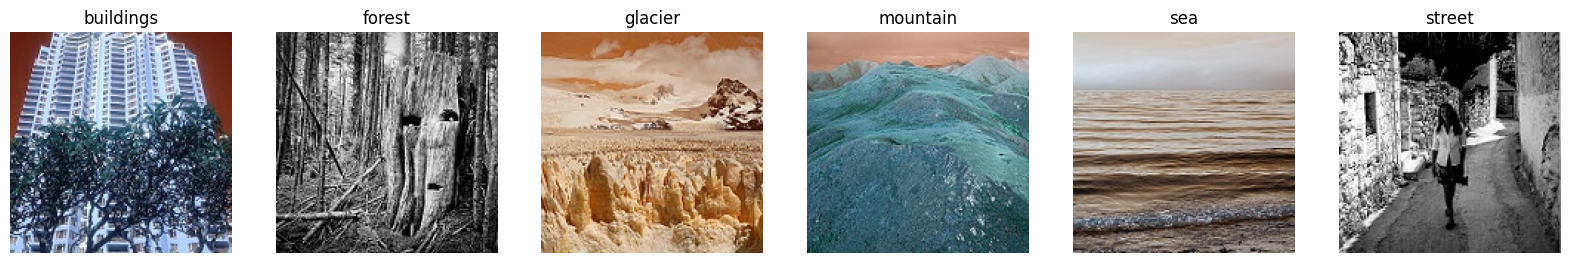

In [8]:
fig, axes = plt.subplots(1, 6, figsize=(20, 20))
for i in range(6):
    axes[i].imshow(X_train[y_train == i][0])
    axes[i].set_title(labels[i])
    axes[i].axis('off')
plt.show()

# display some images from the test data per class
fig, axes = plt.subplots(1, 6, figsize=(20, 20))
for i in range(6):
    axes[i].imshow(X_test[y_test == i][0])
    axes[i].set_title(labels[i])
    axes[i].axis('off')
plt.show()

### Split Training and Validation Data

In [9]:
# one-hot encode the labels
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# split the training data into training and validation data
# 80% of the data will be used for training and 20% for validation
# split the data stratified by the labels
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

In [10]:
print(X_train.shape)
print(y_train.shape)

print(X_val.shape)
print(y_val.shape)

(11227, 150, 150, 3)
(11227, 6)
(2807, 150, 150, 3)
(2807, 6)


### Normalize Data

In [11]:
X_train = X_train / 255.0
X_val = X_val / 255.0
X_test = X_test / 255.0

# Model Architecture MobileNet V2

In [21]:
mobileNet = tf.keras.applications.MobileNetV2(input_shape=(150,150,3), include_top=False,weights='/kaggle/input/mobilenetv2/tensorflow2/mobilenet/1/mobilenet_v2_weights_tf_dim_ordering_tf_kernels_1.0_224_no_top.h5')

In [22]:
for layer in mobileNet.layers:
    layer.trainable = False

In [23]:
model = Sequential()
model.add(mobileNet)
model.add(GlobalAveragePooling2D())
model.add(Dense(6, activation="softmax"))

In [24]:
model.build((None, 150, 150, 3))
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_150            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │         7,686 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,265,670 (8.64 MB)

 Trainable params: 7,686 (30.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [25]:
model.compile(optimizer='RMSprop', loss = "categorical_crossentropy", metrics = ["accuracy"])

### Train Model

In [26]:
history = model.fit(X_train, y_train, epochs=15, validation_data=(X_val, y_val))


Epoch 1/15
  7/351 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - accuracy: 0.2909 - loss: 1.8849

W0000 00:00:1718805236.976091    4207 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.7621 - loss: 0.6297

W0000 00:00:1718805244.872458    4209 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1718805249.971909    4206 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


351/351 ━━━━━━━━━━━━━━━━━━━━ 23s 46ms/step - accuracy: 0.7622 - loss: 0.6292 - val_accuracy: 0.8774 - val_loss: 0.3309
Epoch 2/15
  7/351 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.8378 - loss: 0.3699

W0000 00:00:1718805253.041420    4209 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


351/351 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - accuracy: 0.8864 - loss: 0.3119 - val_accuracy: 0.8906 - val_loss: 0.3099
Epoch 3/15
351/351 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - accuracy: 0.9000 - loss: 0.2693 - val_accuracy: 0.8931 - val_loss: 0.3042
Epoch 4/15
351/351 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - accuracy: 0.9110 - loss: 0.2417 - val_accuracy: 0.8903 - val_loss: 0.3093
Epoch 5/15
351/351 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - accuracy: 0.9235 - loss: 0.2183 - val_accuracy: 0.8824 - val_loss: 0.3318
Epoch 6/15
351/351 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - accuracy: 0.9250 - loss: 0.2116 - val_accuracy: 0.8888 - val_loss: 0.3175
Epoch 7/15
351/351 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - accuracy: 0.9249 - loss: 0.2085 - val_accuracy: 0.8928 - val_loss: 0.3146
Epoch 8/15
351/351 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - accuracy: 0.9317 - loss: 0.1987 - val_accuracy: 0.8949 - val_loss: 0.3047
Epoch 9/15
351/351 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - accuracy: 0.9348 - loss: 0.1865 - val_accuracy: 0.893

## Performance metrics

### Accuracy and Loss

In [27]:
def plot_accuracy_loss(history):
    """
        Plot the accuracy and the loss during the training of the nn.
    """
    fig = plt.figure(figsize=(15, 10))

    # Plot accuracy
    plt.subplot(221)
    plt.plot(history.history['accuracy'], label = "Train Accuracy")
    plt.plot(history.history['val_accuracy'], label = "Validation Accuracy")
    plt.title("Train Accuracy vs Validation Accuracy")
    plt.ylabel("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()

    # Plot loss function
    plt.subplot(222)
    plt.plot(history.history['loss'], label = "Train Loss")
    plt.plot(history.history['val_loss'], label = "Validation Loss")
    plt.title("Train Loss vs Validation Loss")
    plt.ylabel("Loss")
    plt.xlabel("Epochs")

    plt.legend()
    plt.show()

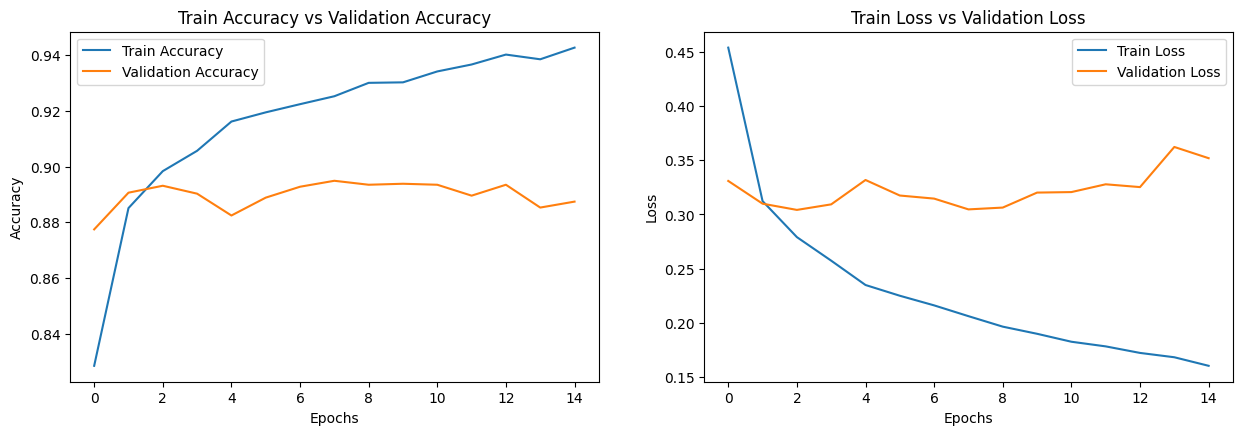

In [28]:
plot_accuracy_loss(history)

### Classification Report and Confusion Matrix

94/94 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step
              precision    recall  f1-score   support

           0       0.94      0.86      0.90       437
           1       0.98      0.99      0.98       474
           2       0.86      0.75      0.80       553
           3       0.76      0.85      0.80       525
           4       0.88      0.90      0.89       510
           5       0.89      0.94      0.91       501

    accuracy                           0.88      3000
   macro avg       0.89      0.88      0.88      3000
weighted avg       0.88      0.88      0.88      3000



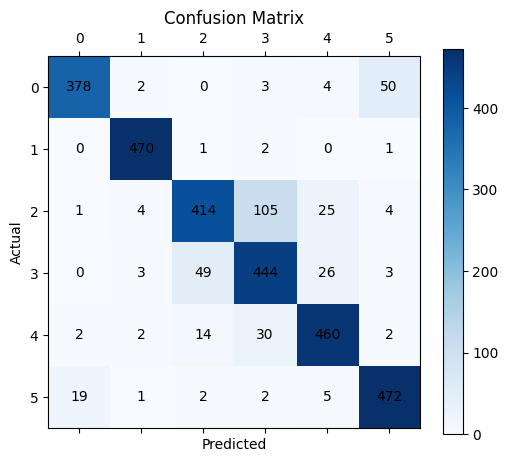

In [29]:
# Confusion Matrix
predictions = model.predict(X_test)
y_pred = np.argmax(predictions, axis=1)
true_labels = np.argmax(y_test, axis=1)  
confusion = confusion_matrix(true_labels, y_pred)

fig, ax = plt.subplots(figsize=(6, 5)) 
cax = ax.matshow(confusion, cmap='Blues')
fig.colorbar(cax)

print(classification_report(true_labels, y_pred))

for (i, j), val in np.ndenumerate(confusion):
    ax.text(j, i, f'{val}', ha='center', va='center')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

### Accuracy of Training, Validation and Testing data

In [30]:
print("Accuracy of the model using training data is - ", model.evaluate(X_train,y_train)[1]*100,"%")
print("Accuracy of the model using validation data is - ", model.evaluate(X_val,y_val)[1]*100,"%")
print("\nAccuracy of the model is - ", model.evaluate(X_test,y_test)[1]*100,"%")

351/351 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - accuracy: 0.9489 - loss: 0.1480


W0000 00:00:1718805424.621873    4206 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Accuracy of the model using training data is -  94.87841725349426 %
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.8819 - loss: 0.3389
Accuracy of the model using validation data is -  88.74242901802063 %
94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - accuracy: 0.8724 - loss: 0.3833

Accuracy of the model is -  87.93333172798157 %


W0000 00:00:1718805434.177534    4206 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


### Plot ROC Curves

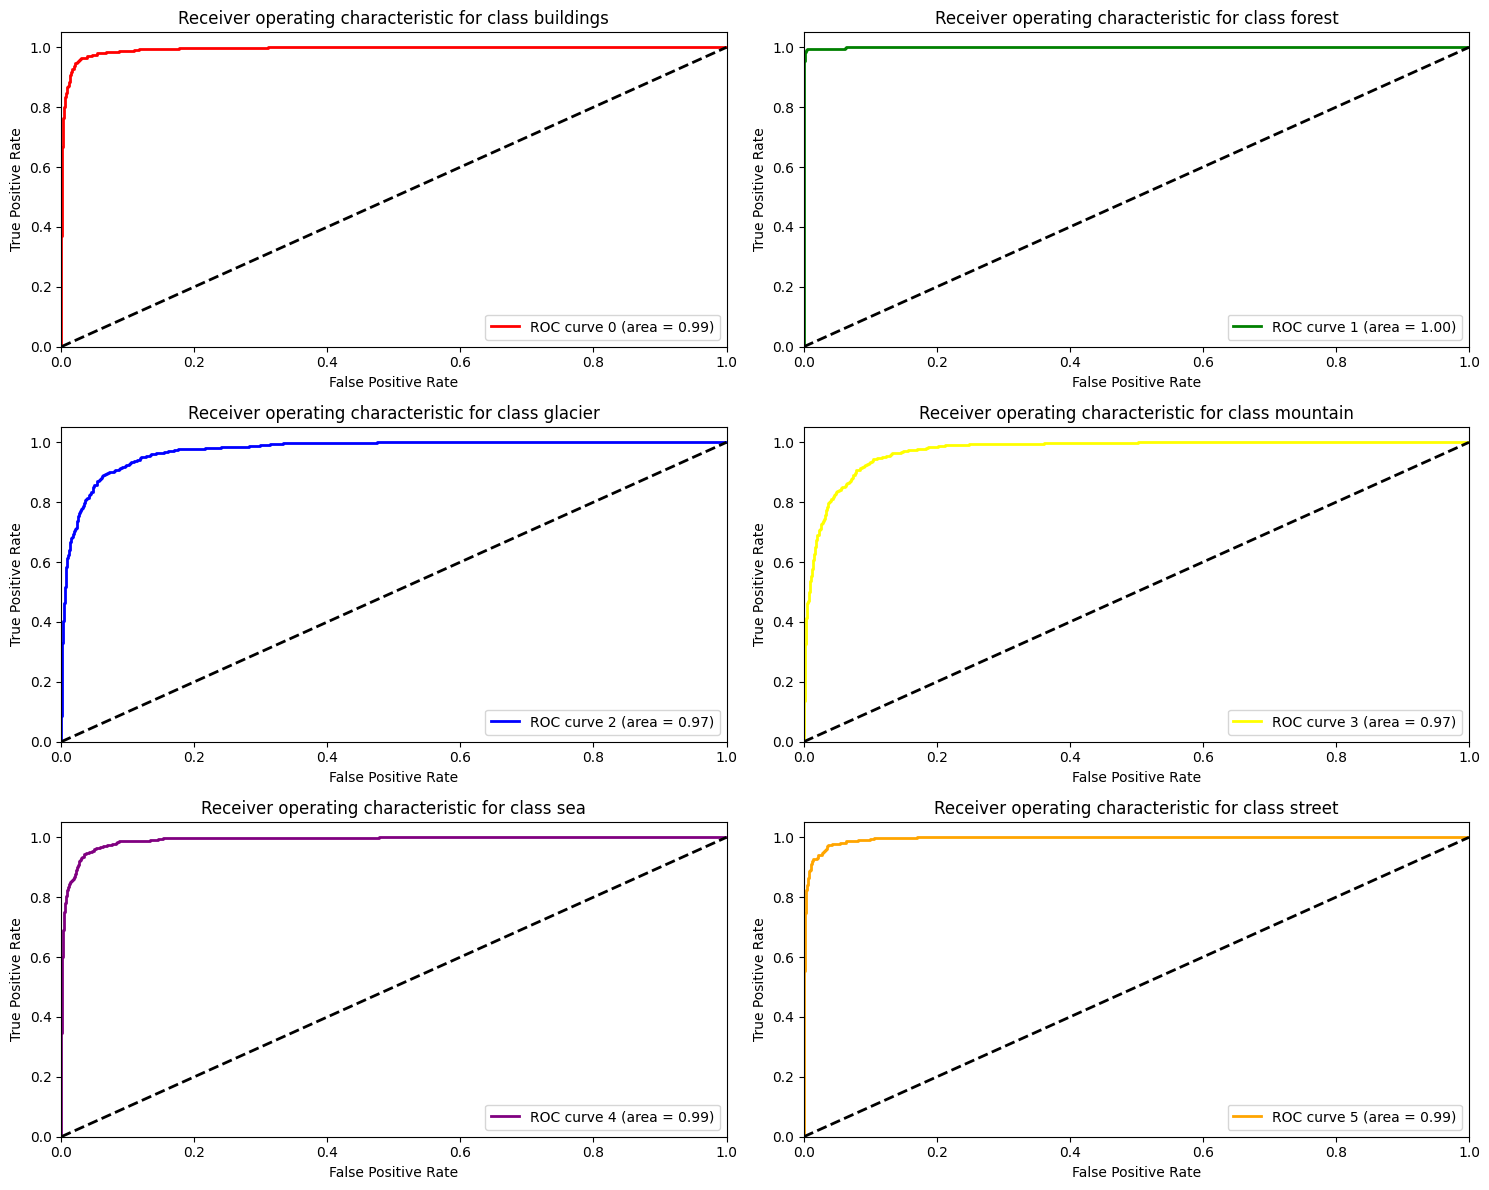

In [31]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

unique_classes = [0, 1, 2, 3, 4, 5]

y_train_bin = label_binarize(y_train, classes=unique_classes)
y_test_bin = label_binarize(y_test, classes=unique_classes)

fpr = dict()
tpr = dict()
roc_auc = dict()

num_classes = len(unique_classes)

# Criação de figuras e subplots
fig, axs = plt.subplots(3, 2, figsize=(15, 12))  # 3 linhas, 2 colunas

# Cores para as classes
colors = ['red', 'green', 'blue', 'yellow', 'purple', 'orange']

# Iteração sobre todas as classes
for i, ax in enumerate(axs.flat):
    # Seleciona a classe atual
    class_index = i % num_classes
    
    # Calcula FPR, TPR e AUC para a classe atual
    fpr[class_index], tpr[class_index], _ = roc_curve(y_test_bin[:, class_index], predictions[:, class_index])
    roc_auc[class_index] = auc(fpr[class_index], tpr[class_index])
    
    # Plota a curva ROC
    ax.plot(fpr[class_index], tpr[class_index], color=colors[class_index % len(colors)], lw=2,
            label=f'ROC curve {class_index} (area = {roc_auc[class_index]:.2f})')
    ax.plot([0, 1], [0, 1], 'k--', lw=2)
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver operating characteristic for class {}'.format(labels.get(class_index)))
    ax.legend(loc="lower right")

plt.tight_layout()  
plt.show()

# MobileNet V2 with More Layers and Hyper Parameter Tunning

In [44]:
from keras_tuner import HyperParameters, BayesianOptimization
from tensorflow.keras.optimizers import Adam, SGD, RMSprop

def build_model(hp):

    mobileNet2 = tf.keras.applications.MobileNetV2(input_shape=(150,150,3), include_top= False,weights='/kaggle/input/mobilenetv2/tensorflow2/mobilenet/1/mobilenet_v2_weights_tf_dim_ordering_tf_kernels_1.0_224_no_top.h5')


    mobileNet2.trainable = True

    #define model
    model2 = tf.keras.Sequential()
    model2.add(mobileNet2)
    model2.add(tf.keras.layers.GlobalAveragePooling2D())
    model2.add(tf.keras.layers.Dense(1024, activation='relu'))
    model2.add(tf.keras.layers.Dropout(0.5))
    model2.add(tf.keras.layers.Dense(512, activation='relu'))
    model2.add(tf.keras.layers.Dropout(0.5))
    model2.add(tf.keras.layers.Dense(6, activation='softmax'))

    model2.build((None, 150, 150, 3))
    
    optimizer_choice = hp.Choice('optimizer', ['adam', 'rmsprop', 'sgd'])
    if optimizer_choice == 'adam':
        optimizer = Adam(learning_rate=hp.Float('learning_rate', 1e-4, 1e-2, sampling='log'))
    elif optimizer_choice == 'rmsprop':
        optimizer = RMSprop(learning_rate=hp.Float('learning_rate', 1e-4, 1e-2, sampling='log'))
    else:
        optimizer = SGD(learning_rate=hp.Float('learning_rate', 1e-4, 1e-2, sampling='log'), momentum=hp.Float('momentum', 0.0, 0.99, sampling='linear'),nesterov=True, weight_decay=hp.Float('weight_decay', 0, 0.01, sampling='linear'))
    
    model2.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    return model2

# Create a HyperParameters instance
hp = HyperParameters()

# Create a Keras Tuner instance
tuner = BayesianOptimization(
    hypermodel=build_model,
    objective='val_accuracy',
    max_trials=12,  
)

tuner.search(X_train, y_train, epochs=15, validation_data=(X_val, y_val))

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print('Best lr:', best_hps.get('learning_rate'))
print('Best optimizer:', best_hps.get('optimizer'))
print('Best momentum:', best_hps.get('momentum'))
print('Best weight_decay:', best_hps.get('weight_decay'))


Reloading Tuner from ./untitled_project/tuner0.json
Best lr: 0.0005297126835427752
Best optimizer: sgd
Best momentum: 0.6308017043308572
Best weight_decay: 0.008993603572209791


In [32]:
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

mobileNet2 = tf.keras.applications.MobileNetV2(input_shape=(150,150,3), include_top= False,weights='/kaggle/input/mobilenetv2/tensorflow2/mobilenet/1/mobilenet_v2_weights_tf_dim_ordering_tf_kernels_1.0_224_no_top.h5')


mobileNet2.trainable = True

#define model
model2 = tf.keras.Sequential()
model2.add(mobileNet2)
model2.add(tf.keras.layers.GlobalAveragePooling2D())
model2.add(tf.keras.layers.Dense(1024, activation='relu'))
model2.add(tf.keras.layers.Dropout(0.5))
model2.add(tf.keras.layers.Dense(512, activation='relu'))
model2.add(tf.keras.layers.Dropout(0.5))
model2.add(tf.keras.layers.Dense(6, activation='softmax'))
#compile model
model2.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=SGD(learning_rate=0.0005297126835427752, momentum=0.6308017043308572, nesterov=True, weight_decay=0.008993603572209791))

model2.build((None, 150, 150, 3))
model2.summary()
    


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_150            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1024)           │     1,311,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 6)              │         3,078 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,097,606 (15.63 MB)

 Trainable params: 4,063,494 (15.50 MB)

 Non-trainable params: 34,112 (133.25 KB)

## Train Model

In [33]:
history = model2.fit(X_train, y_train, epochs=15, validation_data=(X_val, y_val))

Epoch 1/15
  2/351 ━━━━━━━━━━━━━━━━━━━━ 28s 83ms/step - accuracy: 0.1094 - loss: 2.4102   

W0000 00:00:1718805522.857726    4209 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.3050 - loss: 1.7854

W0000 00:00:1718805569.176441    4208 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1718805575.248841    4208 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


351/351 ━━━━━━━━━━━━━━━━━━━━ 105s 160ms/step - accuracy: 0.3054 - loss: 1.7844 - val_accuracy: 0.7873 - val_loss: 0.6392
Epoch 2/15
  1/351 ━━━━━━━━━━━━━━━━━━━━ 41s 118ms/step - accuracy: 0.8125 - loss: 0.7385

W0000 00:00:1718805578.805712    4209 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


351/351 ━━━━━━━━━━━━━━━━━━━━ 22s 62ms/step - accuracy: 0.7362 - loss: 0.7244 - val_accuracy: 0.8215 - val_loss: 0.4652
Epoch 3/15
351/351 ━━━━━━━━━━━━━━━━━━━━ 22s 62ms/step - accuracy: 0.8358 - loss: 0.4669 - val_accuracy: 0.8689 - val_loss: 0.3667
Epoch 4/15
351/351 ━━━━━━━━━━━━━━━━━━━━ 22s 61ms/step - accuracy: 0.8677 - loss: 0.3857 - val_accuracy: 0.8956 - val_loss: 0.3262
Epoch 5/15
351/351 ━━━━━━━━━━━━━━━━━━━━ 22s 61ms/step - accuracy: 0.8864 - loss: 0.3376 - val_accuracy: 0.9027 - val_loss: 0.3017
Epoch 6/15
351/351 ━━━━━━━━━━━━━━━━━━━━ 22s 62ms/step - accuracy: 0.8900 - loss: 0.3182 - val_accuracy: 0.9035 - val_loss: 0.2956
Epoch 7/15
351/351 ━━━━━━━━━━━━━━━━━━━━ 22s 62ms/step - accuracy: 0.9063 - loss: 0.2722 - val_accuracy: 0.9116 - val_loss: 0.2733
Epoch 8/15
351/351 ━━━━━━━━━━━━━━━━━━━━ 22s 61ms/step - accuracy: 0.9160 - loss: 0.2446 - val_accuracy: 0.9156 - val_loss: 0.2648
Epoch 9/15
351/351 ━━━━━━━━━━━━━━━━━━━━ 22s 61ms/step - accuracy: 0.9218 - loss: 0.2235 - val_accurac

## Performance metrics

### Accuracy and Loss

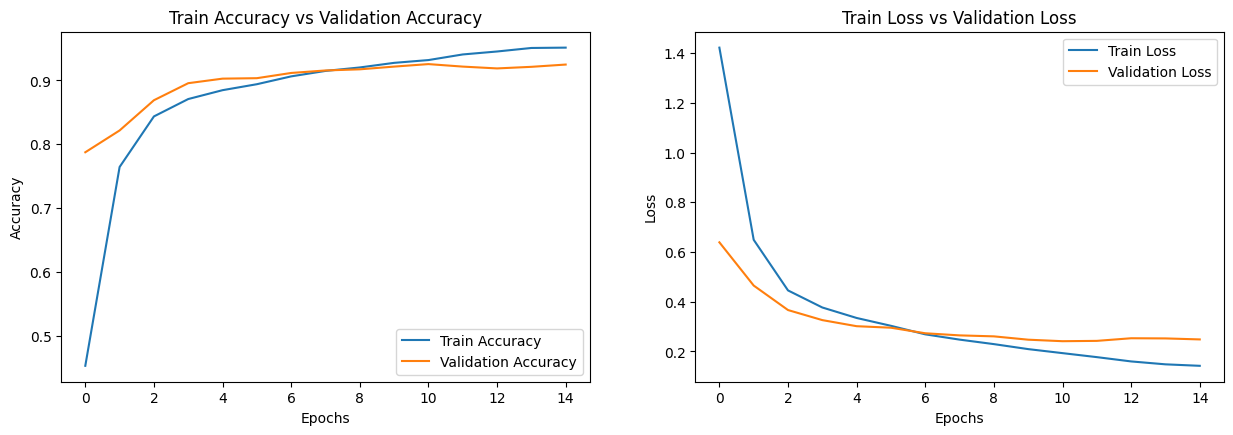

In [34]:
plot_accuracy_loss(history)

### Classification Report and Confusion Matrix

13/94 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step

W0000 00:00:1718805959.833834    4209 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


94/94 ━━━━━━━━━━━━━━━━━━━━ 8s 48ms/step


W0000 00:00:1718805964.299686    4207 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


              precision    recall  f1-score   support

           0       0.93      0.91      0.92       437
           1       0.98      0.99      0.98       474
           2       0.86      0.88      0.87       553
           3       0.89      0.85      0.87       525
           4       0.93      0.95      0.94       510
           5       0.92      0.94      0.93       501

    accuracy                           0.92      3000
   macro avg       0.92      0.92      0.92      3000
weighted avg       0.92      0.92      0.92      3000



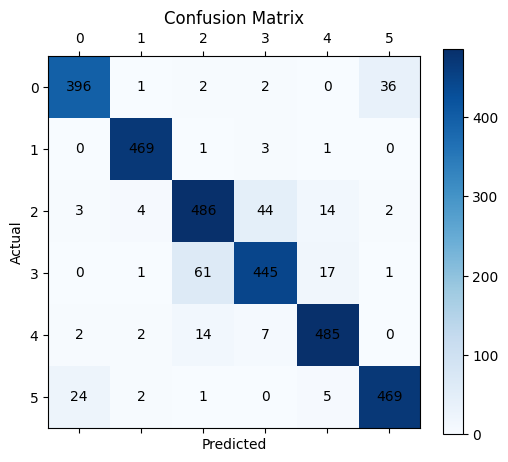

In [35]:
# Confusion Matrix
predictions = model2.predict(X_test)
y_pred = np.argmax(predictions, axis=1)
true_labels = np.argmax(y_test, axis=1)  
confusion = confusion_matrix(true_labels, y_pred)

fig, ax = plt.subplots(figsize=(6, 5)) 
cax = ax.matshow(confusion, cmap='Blues')
fig.colorbar(cax)

print(classification_report(true_labels, y_pred))

for (i, j), val in np.ndenumerate(confusion):
    ax.text(j, i, f'{val}', ha='center', va='center')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

### Accuracy of Training, Validation and Testing data

In [36]:
print("Accuracy of the model using training data is - ", model2.evaluate(X_train,y_train)[1]*100,"%")
print("Accuracy of the model using validation data is - ", model2.evaluate(X_val,y_val)[1]*100,"%")
print("\nAccuracy of the model is - ", model2.evaluate(X_test,y_test)[1]*100,"%")

351/351 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - accuracy: 0.9755 - loss: 0.0755


W0000 00:00:1718805980.741929    4209 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Accuracy of the model using training data is -  97.58617877960205 %
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.9278 - loss: 0.2464
Accuracy of the model using validation data is -  92.48307943344116 %
94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - accuracy: 0.9136 - loss: 0.2473

Accuracy of the model is -  91.66666865348816 %


W0000 00:00:1718805991.273858    4207 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


### Plot ROC Curves

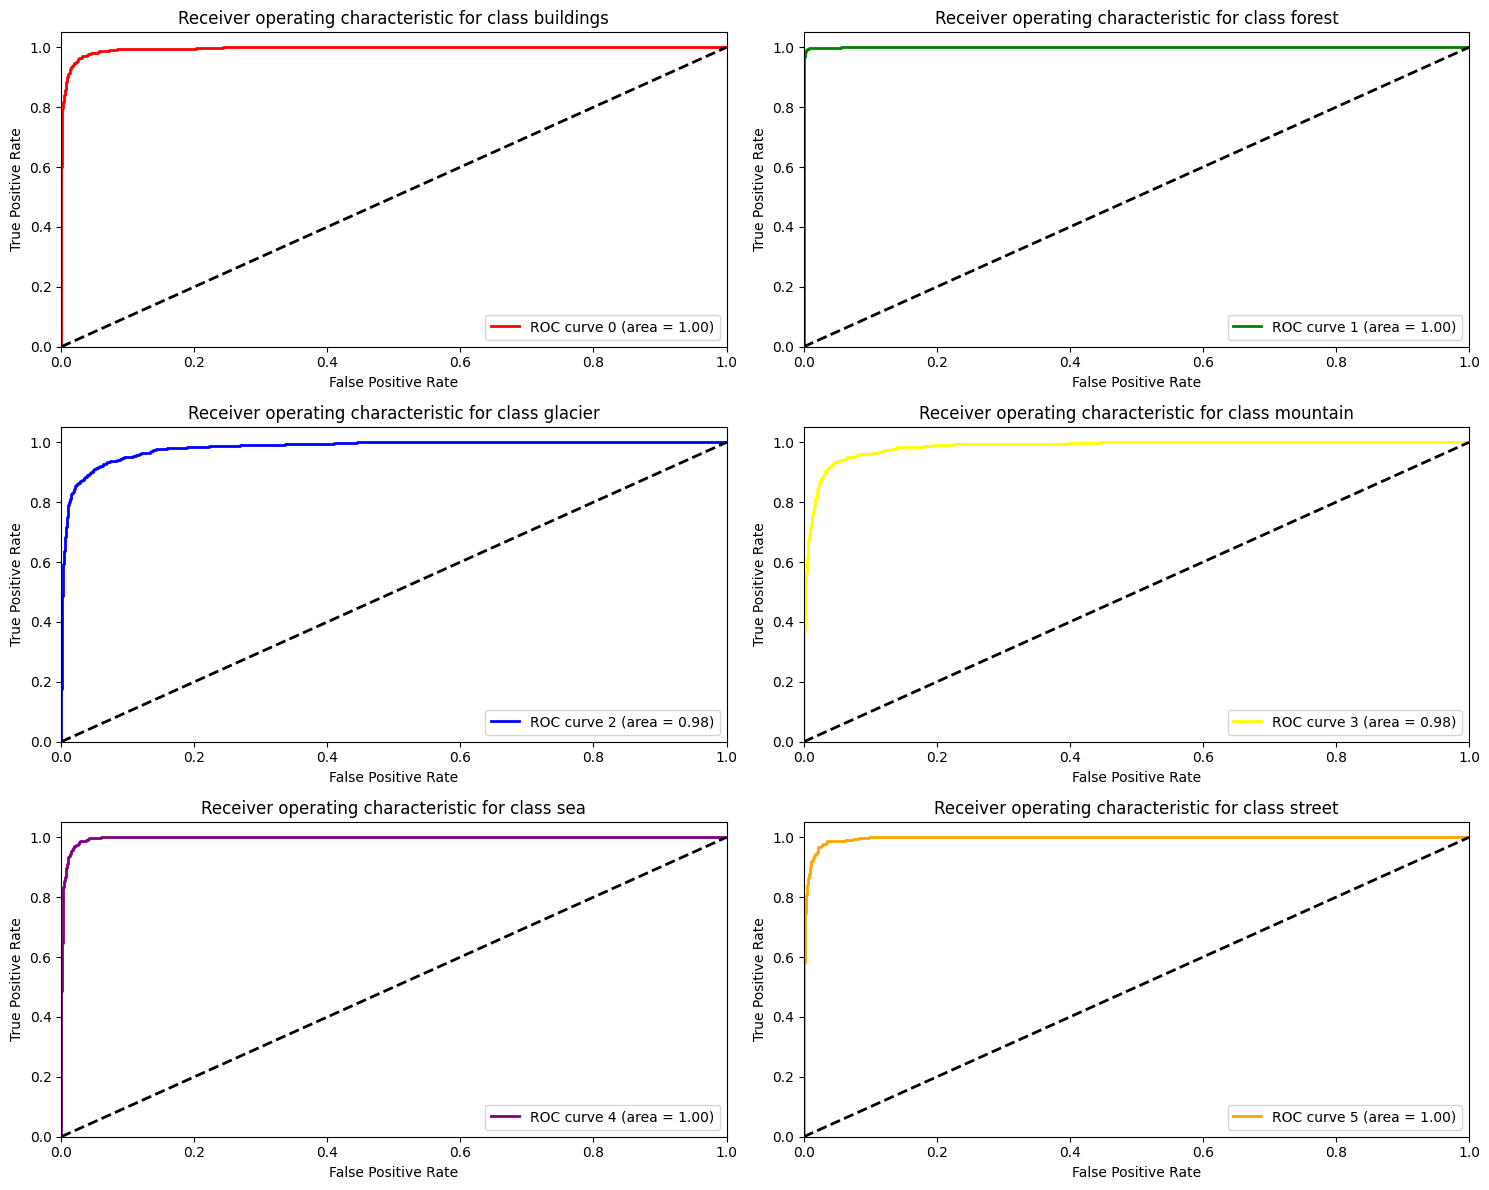

In [37]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

unique_classes = [0, 1, 2, 3, 4, 5]

y_train_bin = label_binarize(y_train, classes=unique_classes)
y_test_bin = label_binarize(y_test, classes=unique_classes)

fpr = dict()
tpr = dict()
roc_auc = dict()

num_classes = len(unique_classes)

# Criação de figuras e subplots
fig, axs = plt.subplots(3, 2, figsize=(15, 12))  # 3 linhas, 2 colunas

# Cores para as classes
colors = ['red', 'green', 'blue', 'yellow', 'purple', 'orange']

# Iteração sobre todas as classes
for i, ax in enumerate(axs.flat):
    # Seleciona a classe atual
    class_index = i % num_classes
    
    # Calcula FPR, TPR e AUC para a classe atual
    fpr[class_index], tpr[class_index], _ = roc_curve(y_test_bin[:, class_index], predictions[:, class_index])
    roc_auc[class_index] = auc(fpr[class_index], tpr[class_index])
    
    # Plota a curva ROC
    ax.plot(fpr[class_index], tpr[class_index], color=colors[class_index % len(colors)], lw=2,
            label=f'ROC curve {class_index} (area = {roc_auc[class_index]:.2f})')
    ax.plot([0, 1], [0, 1], 'k--', lw=2)
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver operating characteristic for class {}'.format(labels.get(class_index)))
    ax.legend(loc="lower right")

plt.tight_layout()  
plt.show()

# Predictions

In [38]:

image_size = (150, 150)

def load_images(path):
    X = []

    for file in os.listdir(os.path.join(path)):
        img = cv2.imread(os.path.join(path, file))
        img = cv2.resize(img, image_size)
        X.append(img)

    return np.array(X)

x_pred = load_images('/kaggle/input/intel-image-classification-mobilenet/seg_pred/seg_pred')

In [39]:
x_pred.shape

(7301, 150, 150, 3)

In [40]:
x_pred = x_pred / 255.0

In [41]:
x_pred_array = np.array(x_pred)
y_result = model2.predict(x_pred_array)
print('Prediction Shape {}'.format(y_result.shape))
y_pred_labels = np.argmax(y_result, axis=1)

229/229 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step
Prediction Shape (7301, 6)


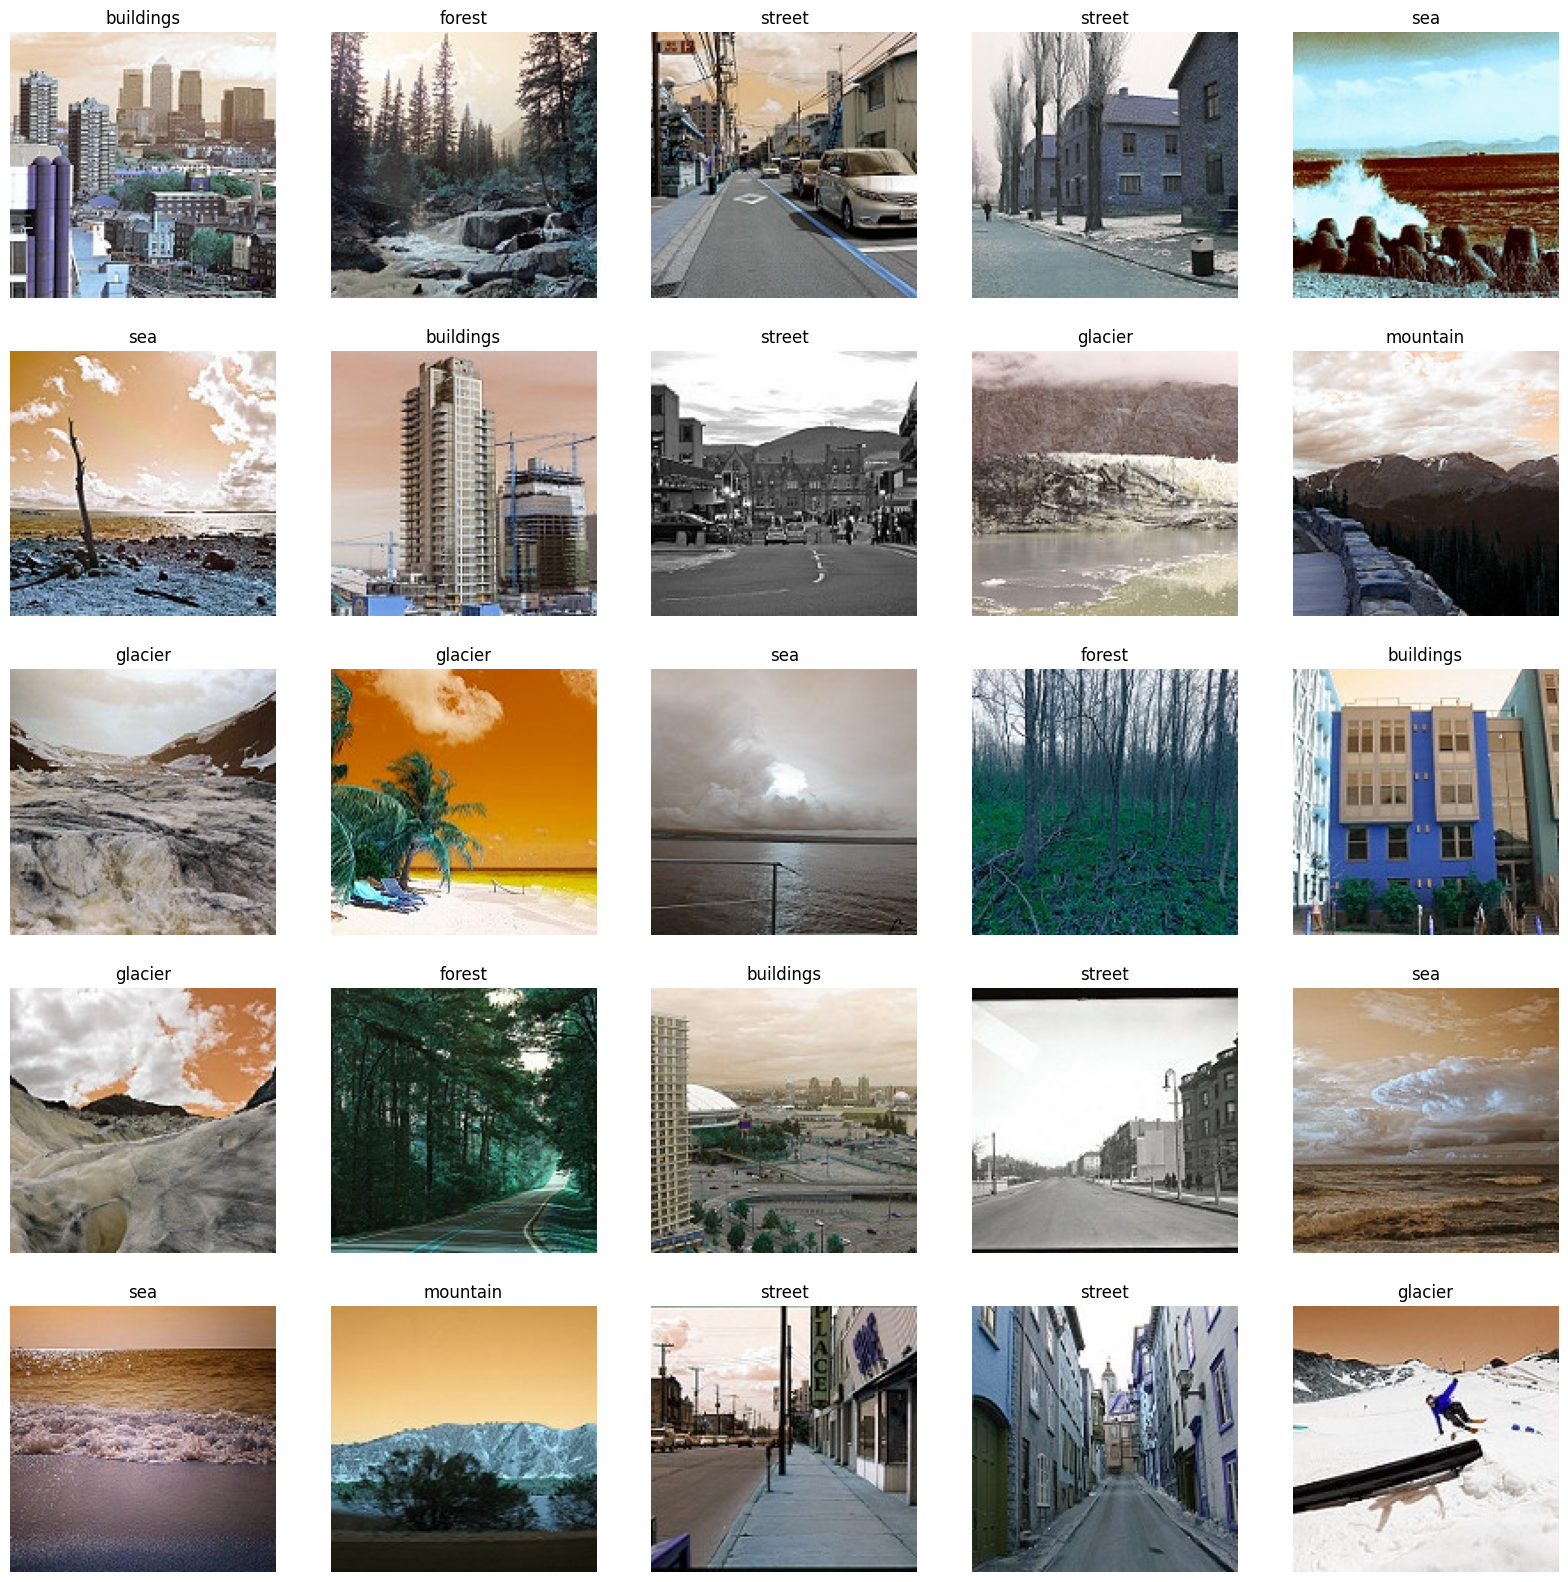

In [43]:
code = {'buildings':0, 'forest':1, 'glacier':2, 'mountain':3, 'sea':4, 'street':5}

def getcode(n):
    for x , y in code.items():
        if n == y :
            return x

plt.figure(figsize=(20, 20))
for n, i in enumerate(list(np.random.randint(0, len(x_pred), 25))):
    plt.subplot(5, 5, n + 1)
    plt.imshow(x_pred[i])
    plt.axis('off')
    plt.title(getcode(y_pred_labels[i]))